In [1]:
import jax
import jax.numpy as jnp
import optax
from jax import grad, jit
import numpy as np

import matplotlib.pyplot as plt

def heatmap_from_array(P, ax=None):  # now accepts ax
    import numpy as np
    n = len(P)
    PX = P[:, 0]
    PY = P[:, 1]

    X = [0.001 * i for i in range(1001)]
    Y = [0.001 * i for i in range(1001)]
    Z = [[0 for _ in range(1001)] for _ in range(1001)]

    maxi = 0
    mxii = 0
    mxjj = 0
    for i in range(1001):
        for j in range(1001):
            Z[j][i] = locdisc(X[i], Y[j], P)
            if Z[j][i] > maxi:
                maxi = Z[j][i]
                mxii = i
                mxjj = j

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))

    cs = ax.contourf(X, Y, Z, levels=40, cmap="viridis")
    plt.colorbar(cs, ax=ax, label="Local Discrepancy")
    ax.scatter(PX, PY, c='r', s=50, linewidth=1, alpha=0.7)
    ax.scatter(mxii/1000, mxjj/1000, c='black')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')

    return ax, maxi

def locdisc(x, y, P):
    no = 0
    nc = 0
    n = len(P)
    for i in range(n):
        if P[i][0] < x and P[i][1] < y:
            no += 1
        if P[i][0] <= x and P[i][1] <= y:
            nc += 1
    return max(x*y - no/n, nc/n - x*y)

def plot_points(P, title="Point Set"):
    P_np = jnp.array(P) if isinstance(P, jax.Array) else P
    plt.figure(figsize=(4, 4))
    plt.scatter(P_np[:, 0], P_np[:, 1], c='blue', s=30)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def softmax(a, b, tau=1e-16):
    return 0.5 * (a + b + jnp.sqrt((a - b)**2 + tau))

# Smoothed L2 star discrepancy function
def L2_smoothed(P, tau=1e-16):
    n = P.shape[0]
    a = jnp.sum((1 - P[:, 0]**2) * (1 - P[:, 1]**2)) / (2 * n)

    # Compute pairwise (i, j) terms using broadcasting
    x = P[:, 0]
    y = P[:, 1]
    xi, xj = jnp.meshgrid(x, x, indexing='ij')
    yi, yj = jnp.meshgrid(y, y, indexing='ij')

    smax0 = softmax(xi, xj, tau)
    smax1 = softmax(yi, yj, tau)
    b = jnp.sum((1 - smax0) * (1 - smax1)) / (n**2)

    return 1/9 - a + b

def fibonacci_lattice(n):
    phi = (jnp.sqrt(5) - 1) / 2  # 1/Golden ratio
    i = jnp.arange(n)
    x = i / n
    y = (i * phi) % 1  # fractional part
    return jnp.stack([x, y], axis=1)


def L2_discrepancy(P):
    N, d = P.shape

    prod1 = 1. - P ** 2
    prod1 = np.prod(prod1, axis=1)
    sum1 = np.sum(prod1)

    # Broadcasting to compute pairwise max across dimensions
    P1 = P[:, np.newaxis, :]  # shape (N, 1, d)
    P2 = P[np.newaxis, :, :]  # shape (1, N, d)
    pairwise_max = np.maximum(P1, P2)  # shape (N, N, d)

    product = np.prod(1. - pairwise_max, axis=2)
    sum2 = np.sum(product)

    one_div_N = 1. / N
    out = np.sqrt(
        np.power(3., -d)
        - one_div_N * np.power(2., 1. - d) * sum1
        + (1. / np.power(N, 2.)) * sum2
    )

    return out




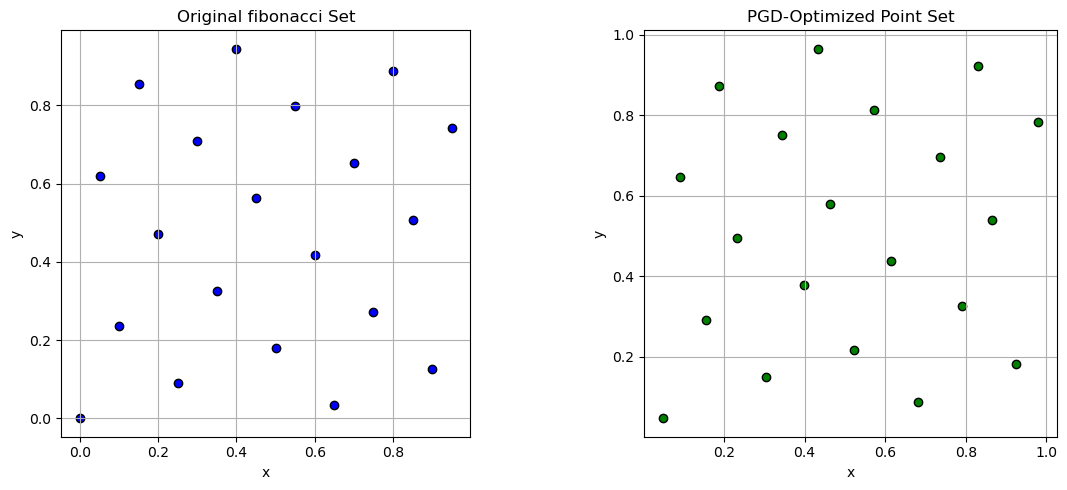

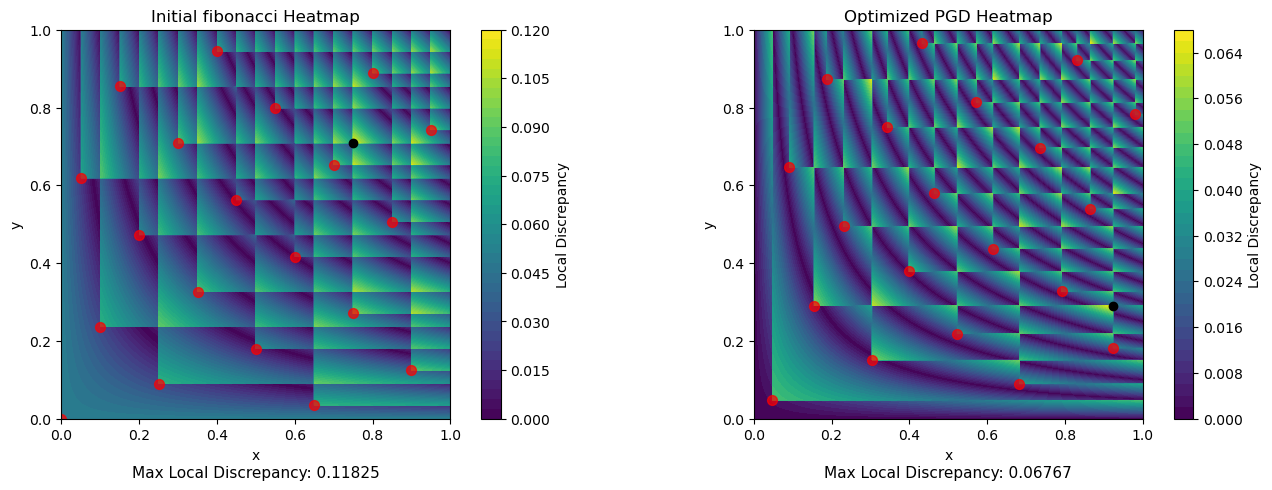

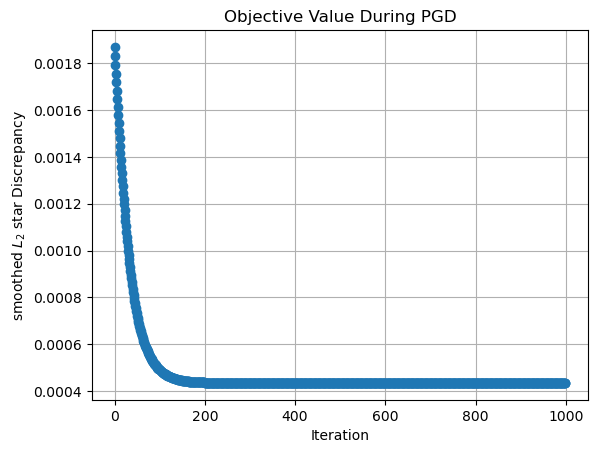

Initial L2 discrepancy: 0.043237260509622316
Final L2 discrepancy value: 0.02086231555011005
Optimized Points:
 [[0.04772257 0.04772257]
 [0.09110093 0.64653248]
 [0.15484352 0.29044953]
 [0.18693979 0.87226897]
 [0.23096517 0.49491647]
 [0.30392495 0.15002245]
 [0.34350052 0.7498076 ]
 [0.39822108 0.37863094]
 [0.43264019 0.96469337]
 [0.46364766 0.57958424]
 [0.52264744 0.21835752]
 [0.57205921 0.81347209]
 [0.61495841 0.4374328 ]
 [0.68244565 0.0891553 ]
 [0.73541379 0.69651538]
 [0.79138684 0.32740596]
 [0.83009702 0.92136699]
 [0.86474735 0.53965789]
 [0.92380685 0.18192913]
 [0.98001254 0.78281248]]


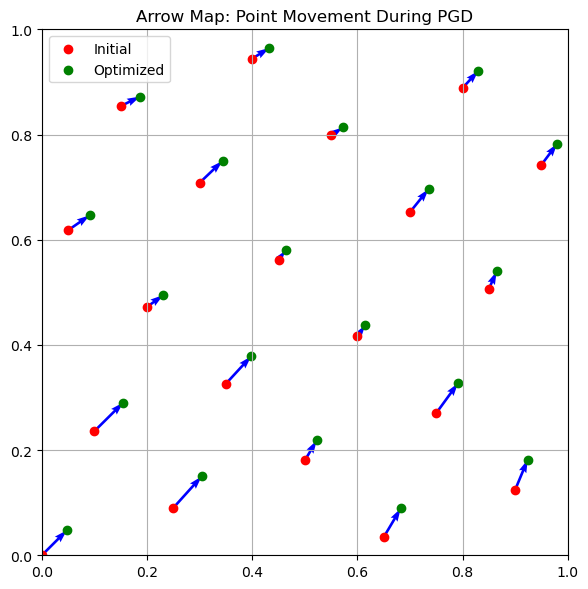

In [18]:
# Use it for initial points
n = 20
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.0005
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

for i in range(1000):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)


# Compute the movement vectors
dx = optimized_points[:, 0] - init_points[:, 0]
dy = optimized_points[:, 1] - init_points[:, 1]

# Plot arrow map
plt.figure(figsize=(6, 6))
plt.quiver(
    init_points[:, 0], init_points[:, 1],  # starting points
    dx, dy,                                # direction vectors
    angles='xy', scale_units='xy', scale=1,
    color='blue', width=0.005
)
plt.scatter(init_points[:, 0], init_points[:, 1], c='red', label='Initial')
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', label='Optimized')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Arrow Map: Point Movement During PGD")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


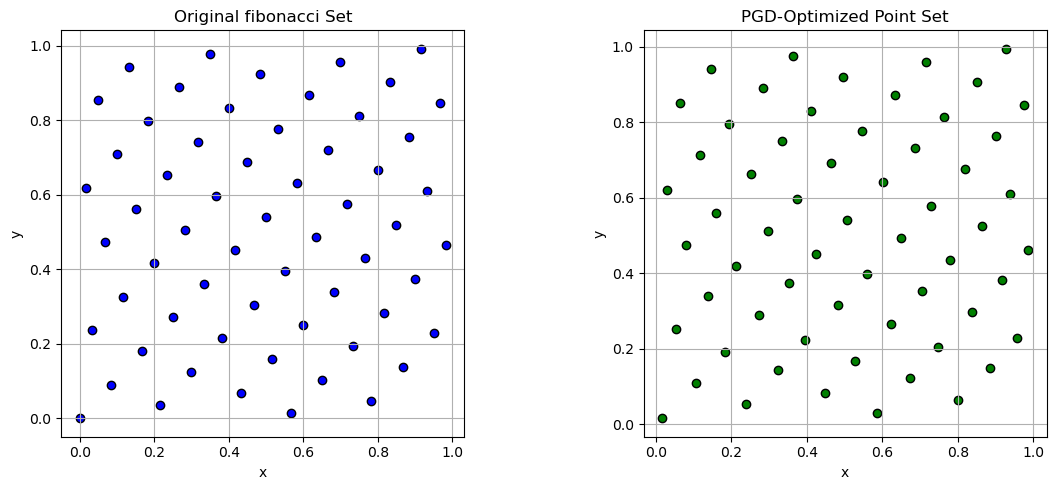

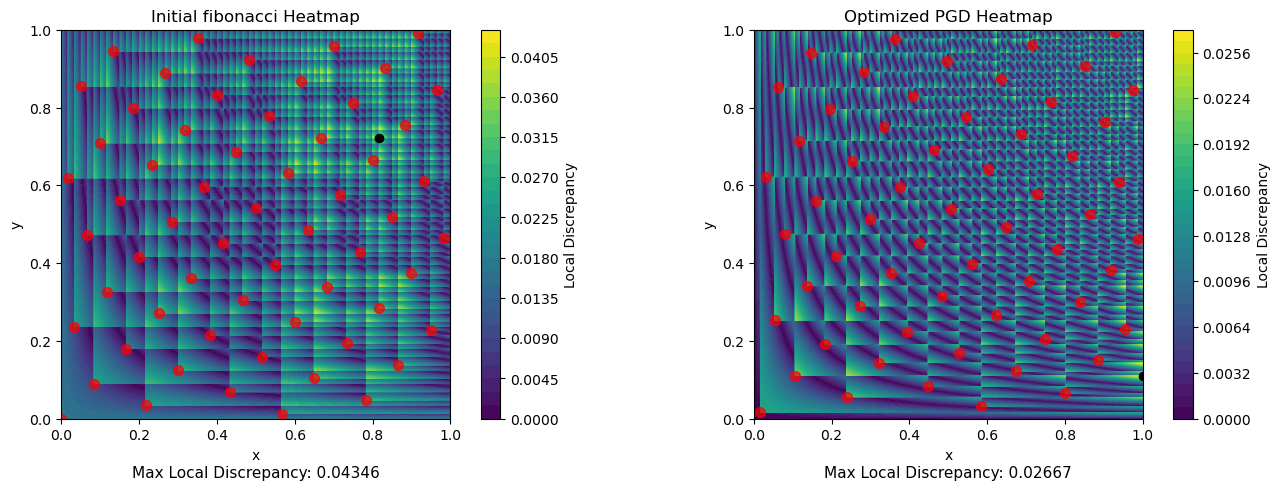

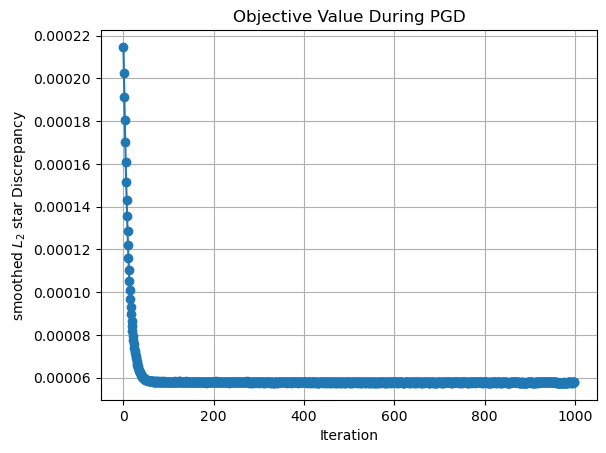

Initial L2 discrepancy: 0.014649880197247047
Final L2 discrepancy value: 0.007605314105091197
Optimized Points:
 [[0.01639778 0.01639778]
 [0.03082639 0.62198615]
 [0.05337737 0.25255156]
 [0.06299947 0.85186666]
 [0.07915206 0.47436765]
 [0.10574797 0.11021376]
 [0.11701371 0.71464753]
 [0.13743147 0.34115109]
 [0.14601977 0.94037592]
 [0.15982218 0.56049854]
 [0.18213426 0.19186877]
 [0.19523342 0.79513836]
 [0.21172561 0.41883039]
 [0.23885483 0.05503302]
 [0.25199541 0.66234332]
 [0.27383569 0.28945538]
 [0.28282645 0.89165562]
 [0.29803994 0.51248389]
 [0.32258597 0.14380114]
 [0.33491668 0.75041687]
 [0.35367566 0.37440932]
 [0.36258247 0.97656173]
 [0.3747533  0.59558898]
 [0.39459023 0.22361888]
 [0.4097997  0.82884997]
 [0.42416644 0.45089674]
 [0.44704172 0.08316532]
 [0.46415424 0.69139469]
 [0.48304918 0.31632113]
 [0.49545643 0.91998643]
 [0.50765502 0.54002136]
 [0.52785015 0.1688263 ]
 [0.5452674  0.77557296]
 [0.56057942 0.39860865]
 [0.58492023 0.03154734]
 [0.60189623

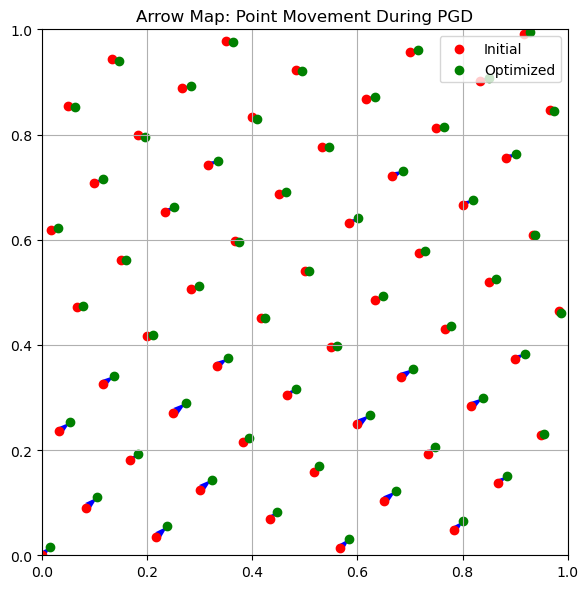

In [16]:
# Use it for initial points
n = 60
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.0005
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

for i in range(1000):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)


# Compute the movement vectors
dx = optimized_points[:, 0] - init_points[:, 0]
dy = optimized_points[:, 1] - init_points[:, 1]

# Plot arrow map
plt.figure(figsize=(6, 6))
plt.quiver(
    init_points[:, 0], init_points[:, 1],  # starting points
    dx, dy,                                # direction vectors
    angles='xy', scale_units='xy', scale=1,
    color='blue', width=0.005
)
plt.scatter(init_points[:, 0], init_points[:, 1], c='red', label='Initial')
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', label='Optimized')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Arrow Map: Point Movement During PGD")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()



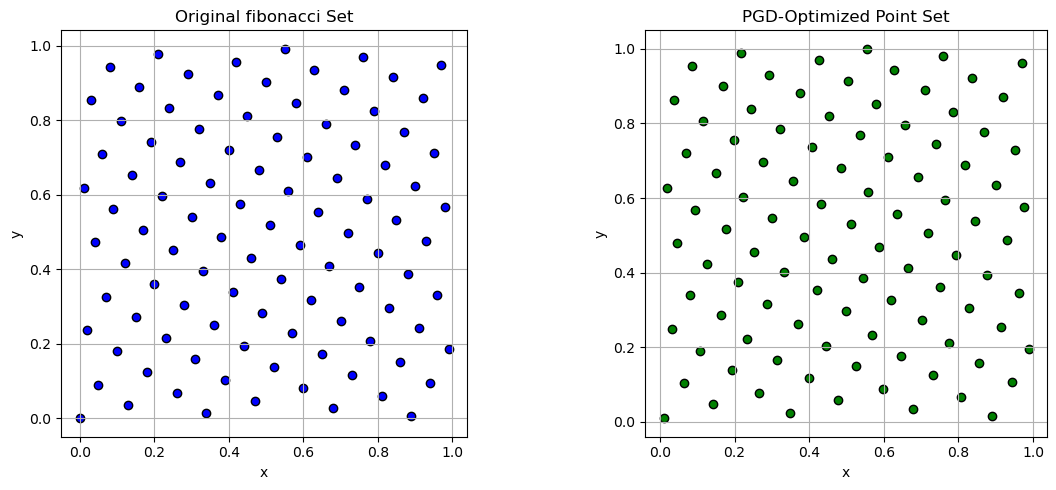

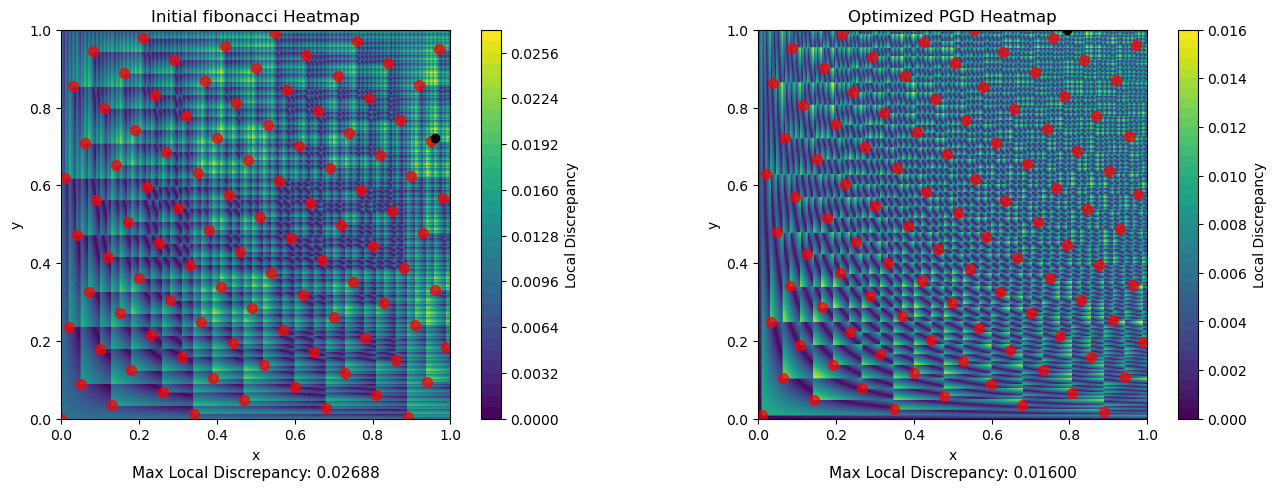

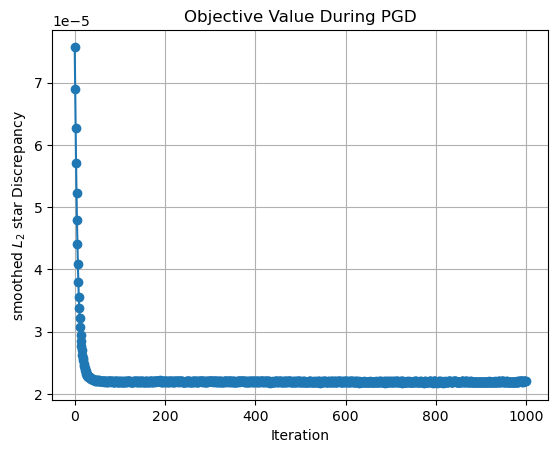

Initial L2 discrepancy: 0.008702476381432738
Final L2 discrepancy value: 0.00468397775277989
Optimized Points:
 [[0.00990195 0.00990195]
 [0.01842455 0.62826234]
 [0.03193954 0.24939156]
 [0.03756323 0.86352497]
 [0.04699185 0.47986555]
 [0.06313527 0.10440139]
 [0.06959026 0.72153276]
 [0.08178739 0.3402487 ]
 [0.08700965 0.95380622]
 [0.09474187 0.56869954]
 [0.10829812 0.19055572]
 [0.11562669 0.80655402]
 [0.12547439 0.4234654 ]
 [0.14227544 0.0483911 ]
 [0.14955792 0.66704208]
 [0.16278996 0.28634056]
 [0.16796726 0.90136129]
 [0.17681767 0.51674378]
 [0.19203375 0.1389306 ]
 [0.19868469 0.7566219 ]
 [0.21005298 0.37391594]
 [0.2162516  0.9884249 ]
 [0.22226597 0.60268408]
 [0.2345667  0.22272365]
 [0.24272987 0.83917022]
 [0.25153872 0.45526752]
 [0.26612648 0.07825452]
 [0.27528414 0.69724333]
 [0.28692809 0.31541884]
 [0.29349631 0.93106902]
 [0.30104706 0.54601246]
 [0.31386539 0.16685119]
 [0.32303515 0.78466958]
 [0.33256549 0.40133214]
 [0.34849539 0.02477858]
 [0.35726014 

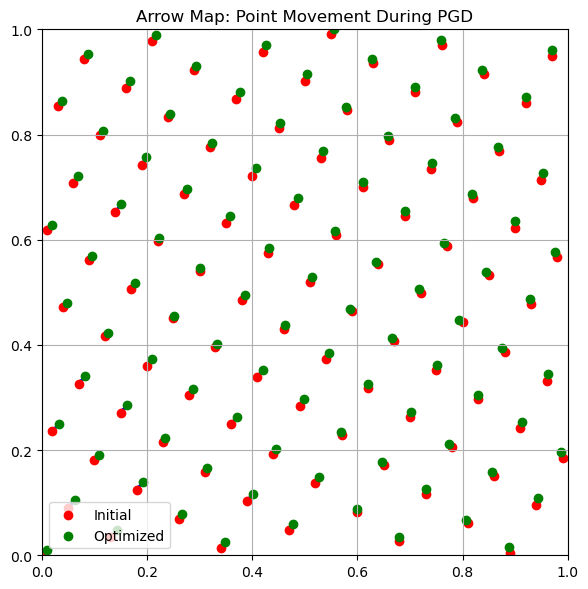

In [2]:
# Use it for initial points
n = 100
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.0005
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

for i in range(1000):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)


# Compute the movement vectors
dx = optimized_points[:, 0] - init_points[:, 0]
dy = optimized_points[:, 1] - init_points[:, 1]

# Plot arrow map
plt.figure(figsize=(6, 6))
plt.quiver(
    init_points[:, 0], init_points[:, 1],  # starting points
    dx, dy,                                # direction vectors
    angles='xy', scale_units='xy', scale=1,
    color='blue', width=0.005
)
plt.scatter(init_points[:, 0], init_points[:, 1], c='red', label='Initial')
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', label='Optimized')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Arrow Map: Point Movement During PGD")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()



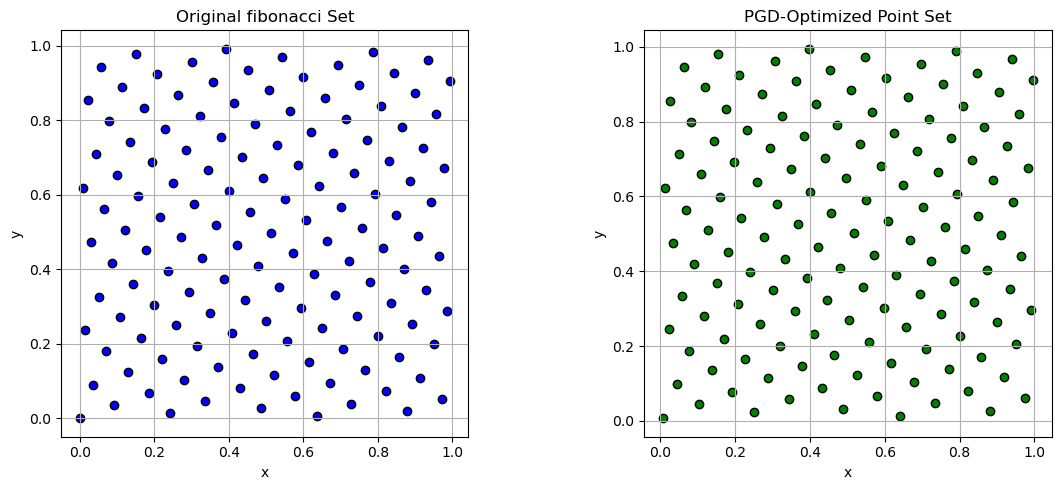

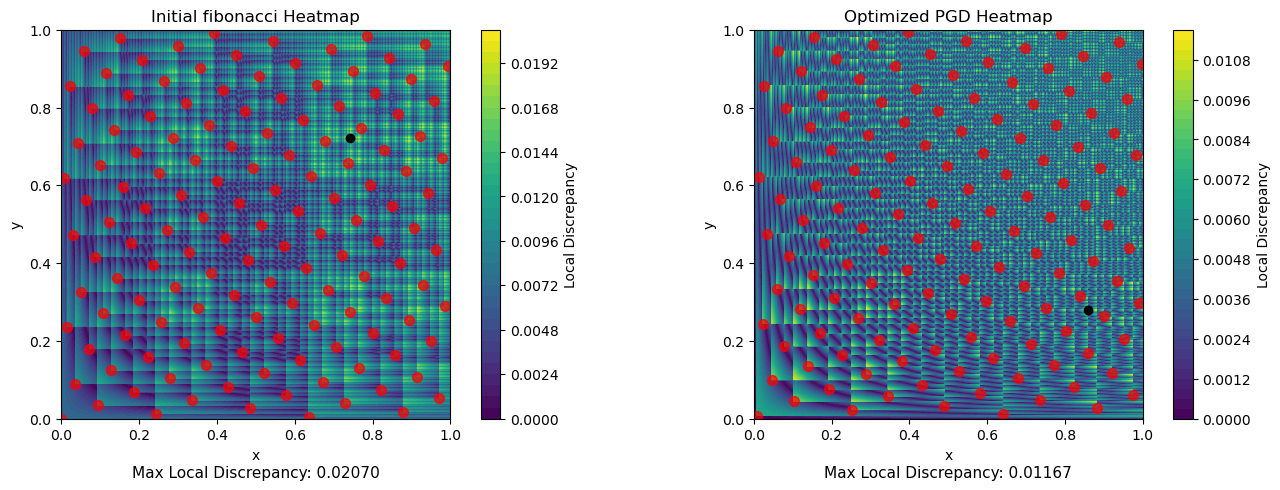

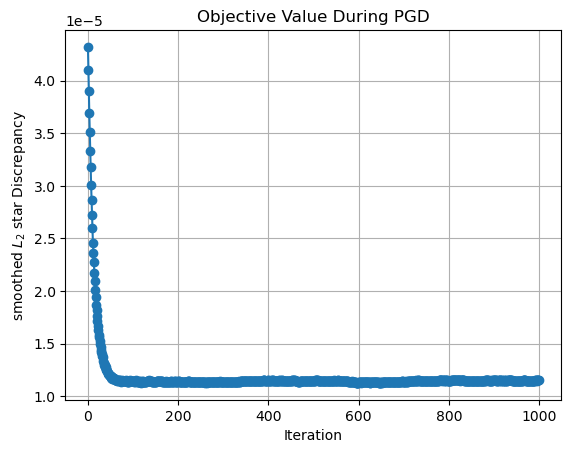

Initial L2 discrepancy: 0.006572032254621162
Final L2 discrepancy value: 0.0033810834220696965
Optimized Points:
 [[0.00709255 0.00709255]
 [0.01321069 0.62206352]
 [0.02296171 0.24443422]
 [0.02693415 0.85637957]
 [0.0338338  0.47521493]
 [0.04548229 0.09998327]
 [0.05002778 0.71390676]
 [0.05889961 0.33454546]
 [0.06240201 0.94590807]
 [0.06829145 0.56370288]
 [0.07810991 0.1866757 ]
 [0.08324424 0.79976213]
 [0.09042571 0.41915029]
 [0.10265353 0.0445087 ]
 [0.1076818  0.65955007]
 [0.11732823 0.28082862]
 [0.12078179 0.89319915]
 [0.12742971 0.51144296]
 [0.1385377  0.13481775]
 [0.14302863 0.74898362]
 [0.15139067 0.36875769]
 [0.15507577 0.9805975 ]
 [0.16026275 0.59799284]
 [0.16924301 0.21987915]
 [0.17488512 0.83317643]
 [0.1813349  0.45195711]
 [0.192068   0.07597831]
 [0.19831343 0.69103277]
 [0.20683302 0.3114621 ]
 [0.21136686 0.92407066]
 [0.21697877 0.54195279]
 [0.22639257 0.16444287]
 [0.2326377  0.77866393]
 [0.23965171 0.39798364]
 [0.25145841 0.02260409]
 [0.2573421

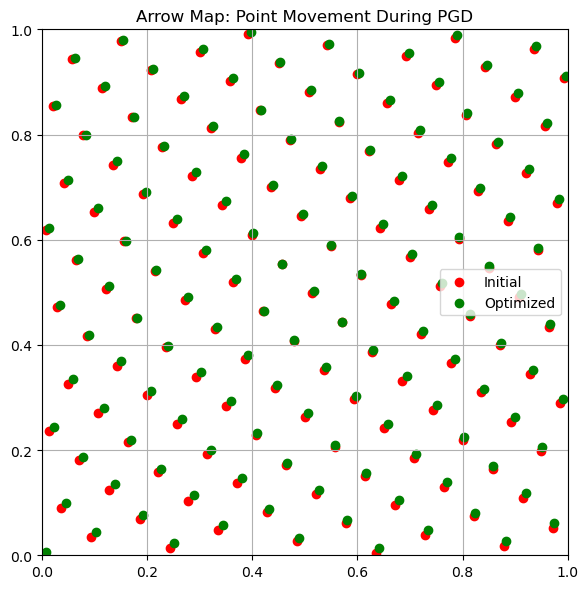

In [10]:
# Use it for initial points
n = 140
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.0002
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

for i in range(1000):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)


# Compute the movement vectors
dx = optimized_points[:, 0] - init_points[:, 0]
dy = optimized_points[:, 1] - init_points[:, 1]

# Plot arrow map
plt.figure(figsize=(6, 6))
plt.quiver(
    init_points[:, 0], init_points[:, 1],  # starting points
    dx, dy,                                # direction vectors
    angles='xy', scale_units='xy', scale=1,
    color='blue', width=0.005
)
plt.scatter(init_points[:, 0], init_points[:, 1], c='red', label='Initial')
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', label='Optimized')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Arrow Map: Point Movement During PGD")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()



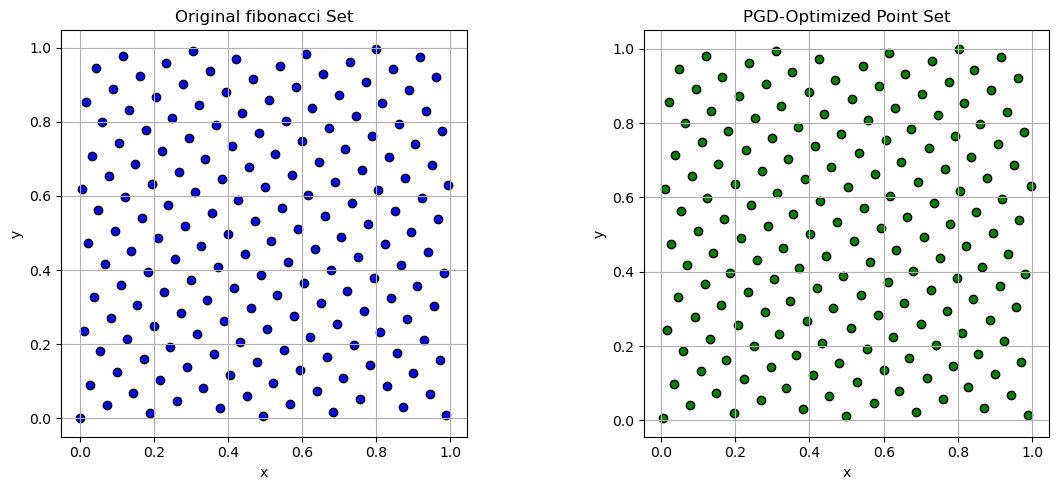

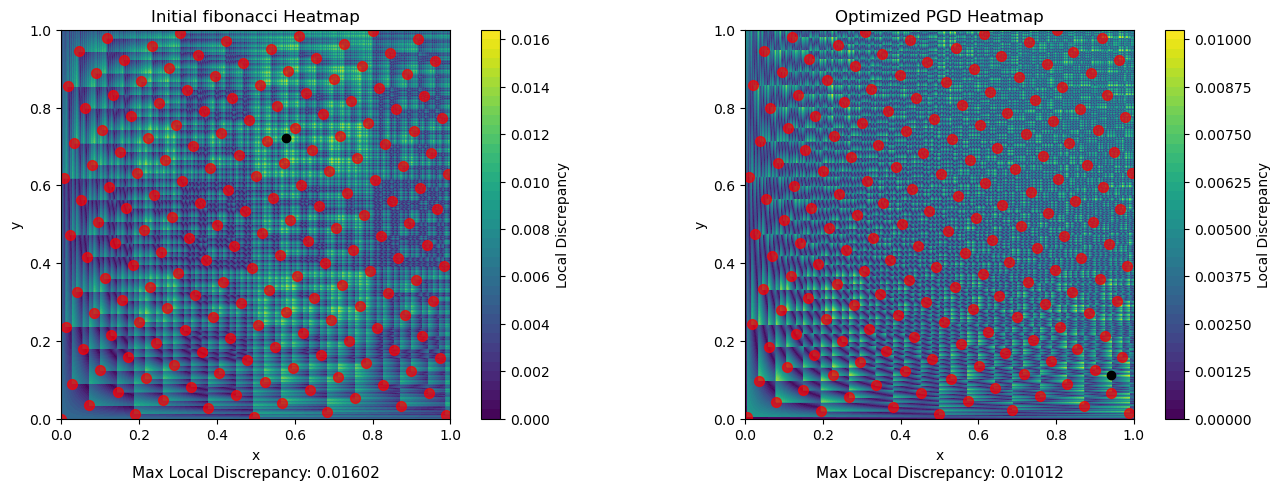

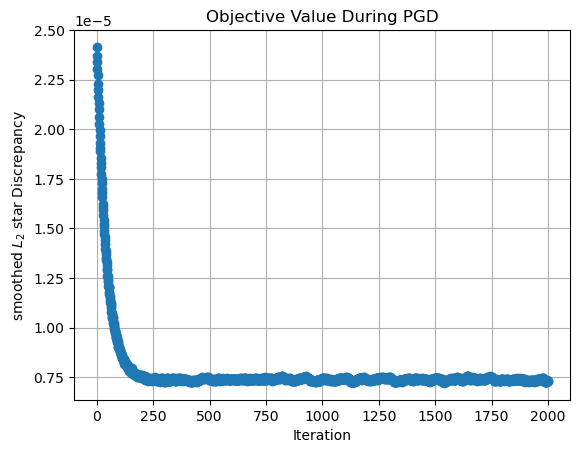

Initial L2 discrepancy: 0.004916913916361618
Final L2 discrepancy value: 0.0027158614284209064
Optimized Points:
 [[0.00552503 0.00552503]
 [0.01027612 0.62188488]
 [0.01787493 0.24281853]
 [0.02094403 0.85680264]
 [0.02631266 0.47494754]
 [0.03541474 0.09782088]
 [0.03890775 0.7133128 ]
 [0.04583393 0.33291152]
 [0.04852152 0.94644552]
 [0.05311241 0.56378961]
 [0.06079731 0.1852382 ]
 [0.06471458 0.80001378]
 [0.07032916 0.41860172]
 [0.07994588 0.04200444]
 [0.08375463 0.65828657]
 [0.09132046 0.27841368]
 [0.09392444 0.89263827]
 [0.09913796 0.51036352]
 [0.1078946  0.1322781 ]
 [0.11124244 0.74789476]
 [0.11782064 0.36688575]
 [0.1206082  0.98070353]
 [0.12469021 0.59775674]
 [0.13177826 0.21844882]
 [0.13600294 0.83333206]
 [0.14109032 0.45148477]
 [0.14961913 0.07395224]
 [0.154266   0.6902222 ]
 [0.16099249 0.30973902]
 [0.16434725 0.92411   ]
 [0.16881096 0.54154056]
 [0.1762955  0.1627315 ]
 [0.18091528 0.77829689]
 [0.18648124 0.39687502]
 [0.19594106 0.01985698]
 [0.2002321

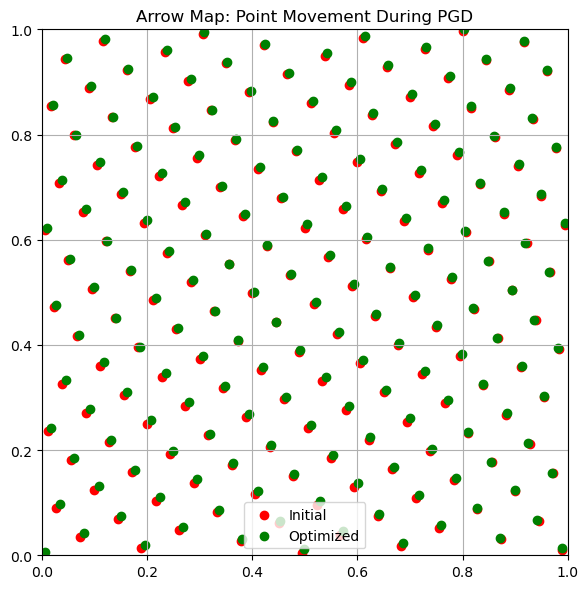

In [12]:
# Use it for initial points
n = 180
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.00005
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

for i in range(2000):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)


# Compute the movement vectors
dx = optimized_points[:, 0] - init_points[:, 0]
dy = optimized_points[:, 1] - init_points[:, 1]

# Plot arrow map
plt.figure(figsize=(6, 6))
plt.quiver(
    init_points[:, 0], init_points[:, 1],  # starting points
    dx, dy,                                # direction vectors
    angles='xy', scale_units='xy', scale=1,
    color='blue', width=0.005
)
plt.scatter(init_points[:, 0], init_points[:, 1], c='red', label='Initial')
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', label='Optimized')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Arrow Map: Point Movement During PGD")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

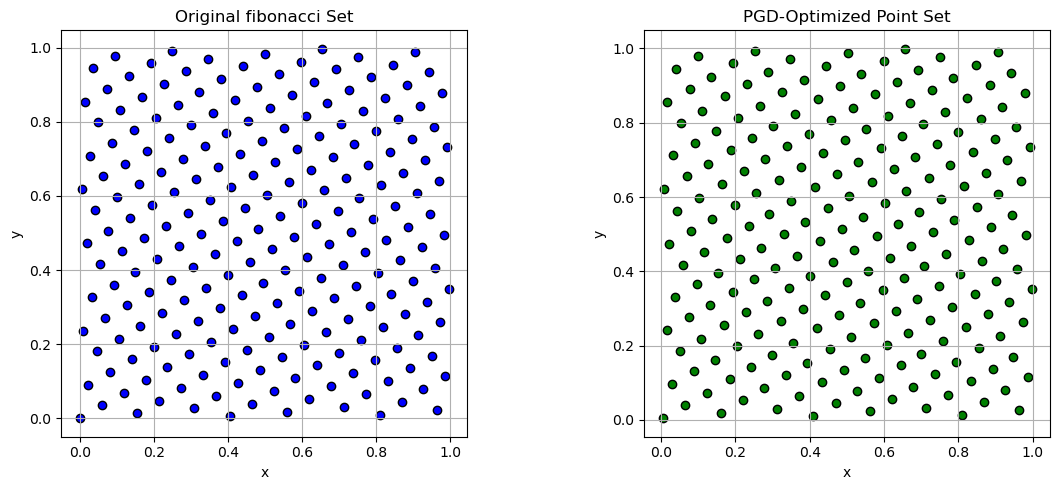

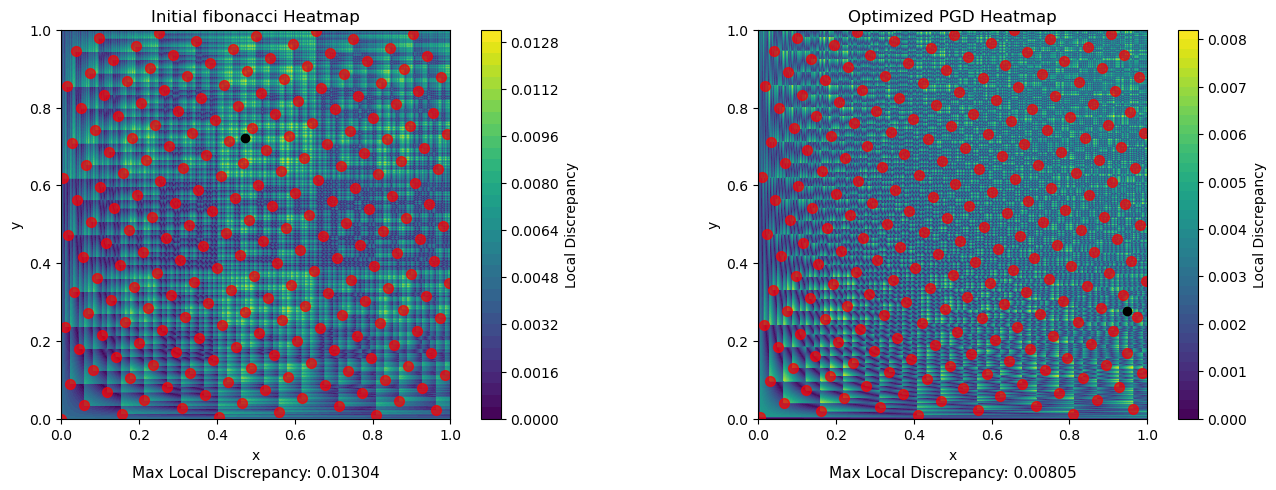

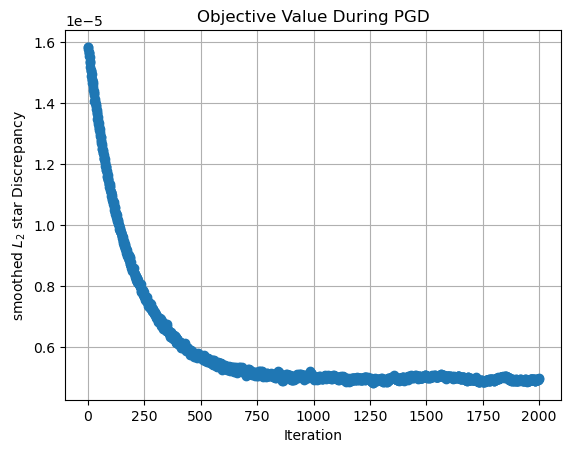

Initial L2 discrepancy: 0.003985410453478598
Final L2 discrepancy value: 0.0022321531519474084
Optimized Points:
 [[0.00452496 0.00452496]
 [0.00841248 0.62096781]
 [0.01464257 0.24152033]
 [0.01714321 0.85602838]
 [0.02155031 0.47430062]
 [0.02901796 0.09647154]
 [0.03185822 0.71221727]
 [0.03754441 0.33170864]
 [0.03971268 0.94579923]
 [0.04350194 0.56339872]
 [0.04981268 0.18439633]
 [0.05298644 0.79950875]
 [0.0575979  0.4181501 ]
 [0.06550947 0.04079063]
 [0.06858575 0.65714741]
 [0.07480109 0.27708048]
 [0.07689343 0.89170122]
 [0.08119529 0.50961953]
 [0.08840335 0.13102777]
 [0.09108768 0.74678695]
 [0.09650508 0.36577803]
 [0.09871372 0.98001784]
 [0.1021301  0.59739119]
 [0.10796707 0.2178227 ]
 [0.11136659 0.83298182]
 [0.11555534 0.45129082]
 [0.12260204 0.07323288]
 [0.12632756 0.68955445]
 [0.13186523 0.30903015]
 [0.13455252 0.92372727]
 [0.13824633 0.54141152]
 [0.14442314 0.16227074]
 [0.14812154 0.77797228]
 [0.15271051 0.39663762]
 [0.16054597 0.01903411]
 [0.1639659

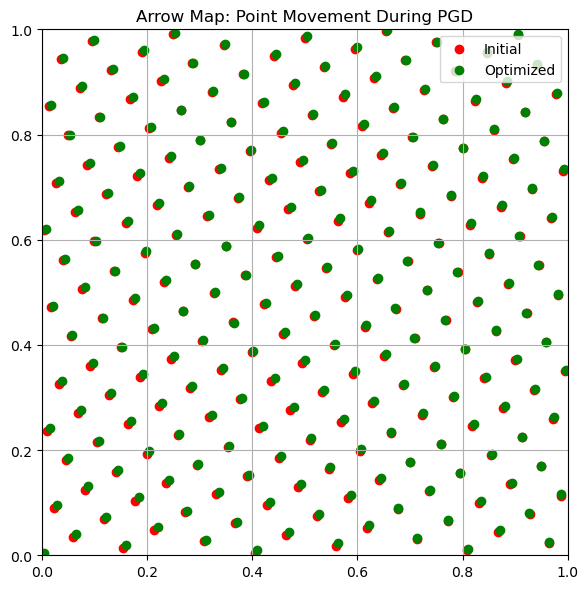

In [14]:
# Use it for initial points
n = 220
P_init = fibonacci_lattice(n)

# ADAM optimizer setup
learning_rate = 0.00001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(P_init)

# Define loss function and gradient
loss_fn = lambda P: L2_smoothed(P)
loss_and_grad = jax.value_and_grad(loss_fn)

# Optimization loop
P = P_init
objective_history = []

for i in range(2000):
    loss_val, grads = loss_and_grad(P)
    updates, opt_state = optimizer.update(grads, opt_state)
    P = optax.apply_updates(P, updates)

    # Clamp to [0, 1]^2
    P = jnp.clip(P, 0.0, 1.0)
    objective_history.append(loss_val)


init_points = np.asarray(P_init).astype(np.float64)
optimized_points = np.asarray(P).astype(np.float64)
initial_discrepancy_value = L2_discrepancy(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("smoothed $L_2$ star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 discrepancy:", initial_discrepancy_value)
print("Final L2 discrepancy value:", L2_discrepancy(optimized_points))
print("Optimized Points:\n", optimized_points)


# Compute the movement vectors
dx = optimized_points[:, 0] - init_points[:, 0]
dy = optimized_points[:, 1] - init_points[:, 1]

# Plot arrow map
plt.figure(figsize=(6, 6))
plt.quiver(
    init_points[:, 0], init_points[:, 1],  # starting points
    dx, dy,                                # direction vectors
    angles='xy', scale_units='xy', scale=1,
    color='blue', width=0.005
)
plt.scatter(init_points[:, 0], init_points[:, 1], c='red', label='Initial')
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', label='Optimized')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Arrow Map: Point Movement During PGD")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()